In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from bumps.names import *
from bumps.fitters import fit

import sasmodels

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

import bumps

# Sage and Lorenzo, edit the path to sasview for sas below
import sas


In [2]:
# sample meta-data
sample_info = pd.read_csv('../../data/sans/Liquid_Samples/Sample_Info.csv')

# helpful meta-data dictionaries
names = dict(zip(sample_info['Sample'], sample_info['Name']))
cps = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer']))
matrix = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer']))
cp_conc = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer Concentration']))
matrix_conc = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer Concentration']))
solvent_names = dict(zip(sample_info['Sample'], sample_info['Solvent']))

In [3]:
names = {'TU11': 'RRe-P3HT at 5 mg/mL',
 'TU19': 'RRe-P3HT at 5 mg/mL + PS-H8 at 45 mg/mL\n(corresponds to 10 wt% solid samples)',
 'TU20': 'PS-H8 at 45 mg/mL',
 'TU24': 'RRe-P3HT at 5 mg/mL + PS-D8 at 45 mg/mL\n(corresponds to 10 wt% solid samples)',
 'TU25': 'PS-D8 at 45 mg/mL'}

In [4]:
slds = {'RRe-P3HT':0.676,
       'Polystyrene-D8':6.464, # density of 1.13 g/mL
       'Polystyrene-H8':1.426,
       'Toluene-D8':5.664}


In [5]:
file_info = pd.read_csv('../../data/sans/Liquid_Samples/File_Info.csv')
file_assign = dict(zip(file_info['Filename'], file_info['Sample']))

data_dir = '../../data/sans/Liquid_Samples/'
files = os.listdir(data_dir)
sans_data = {}
usans_data = {}
for file in files:
    if 'USANS' in file:
        key = str(file.split('_')[0][:4])
        usans_data[key] = np.loadtxt(data_dir + file,skiprows=4)
    elif 'sans' in file:
        key = file_assign[file]
        if key in sans_data.keys():
            sans_data[key].append(np.loadtxt((data_dir + file),skiprows=12))
        else:
            sans_data[key] = [np.loadtxt((data_dir + file),skiprows=12)]
            
for key, (data1, data2) in sans_data.items():
    x = np.concatenate((data1[:,0], data2[:,0]))
    y = np.concatenate((data1[:,1], data2[:,1]))
    dx = np.concatenate((data1[:,3], data2[:,3]))
    dy = np.concatenate((data1[:,2], data2[:,2]))
    sans_data[key] = sasmodels.data.Data1D(x, y, dx=dx, dy=dy)
    
for key, data in usans_data.items():
    usans_data[key] = sasmodels.data.Data1D(data[:,0],data[:,1],dy=data[:,2])

In [6]:
for key, data in sans_data.items():
    filename = 'Merged_' + key + '.ABS'
    x = data.x
    y = data.y
    dy = data.dy
    
    comb = np.vstack((x,y,dy)).T
    np.savetxt('../../data/sans/Liquid_Samples/' + filename, comb, header='<X> <Y> <dY>')

In [7]:
usans_data

{'TU11': <sasmodels.data.Data1D at 0x1221a24f0>,
 'TU19': <sasmodels.data.Data1D at 0x1221a2640>,
 'TU20': <sasmodels.data.Data1D at 0x1221d1df0>}

In [8]:
colors = {
    'TU11':'firebrick',
    'TU19':'mediumblue',
    'TU20':'darkorchid',
    'TU24':'darkcyan',
    'TU25':'black',
}

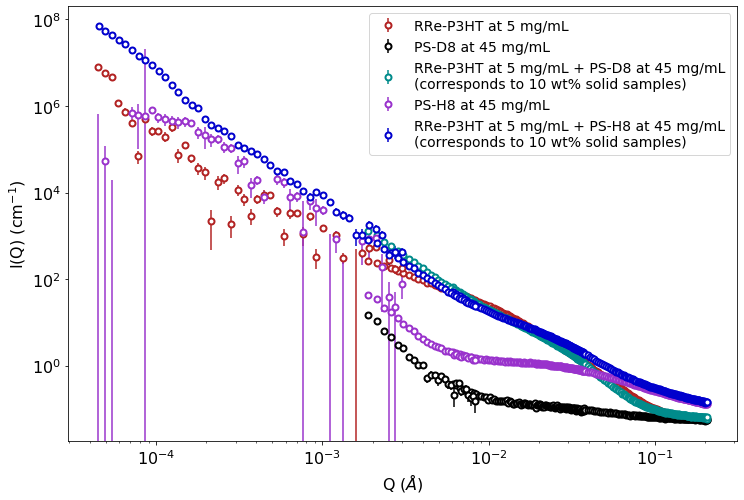

In [9]:
plt.figure(figsize=(12,8))
keys = ['TU11','TU25','TU24','TU20','TU19']
for key,color in zip(keys,colors):
    sans_load = sans_data[key]
    plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],label=names[key],mfc='white',mew=2)
    if key in usans_data.keys():
        usans = usans_data[key]
        plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mfc='white',mew=2)

plt.legend(fontsize=14)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Q $(\AA)$',fontsize=16)
plt.ylabel(r'I(Q) (cm$^{-1}$)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

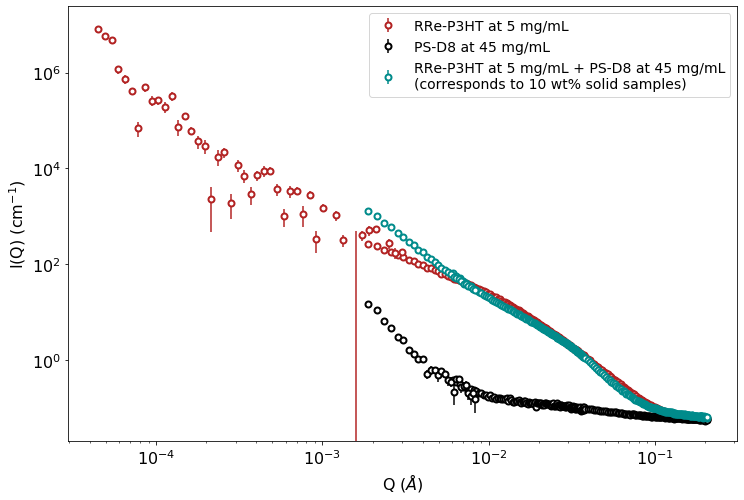

In [10]:
plt.figure(figsize=(12,8))
keys = ['TU11','TU25','TU24']
for key,color in zip(keys,colors):
    sans_load = sans_data[key]
    plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],label=names[key],mfc='white',mew=2)
    if key in usans_data.keys():
        usans = usans_data[key]
        plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mfc='white',mew=2)

plt.legend(fontsize=14)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Q $(\AA)$',fontsize=16)
plt.ylabel(r'I(Q) (cm$^{-1}$)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

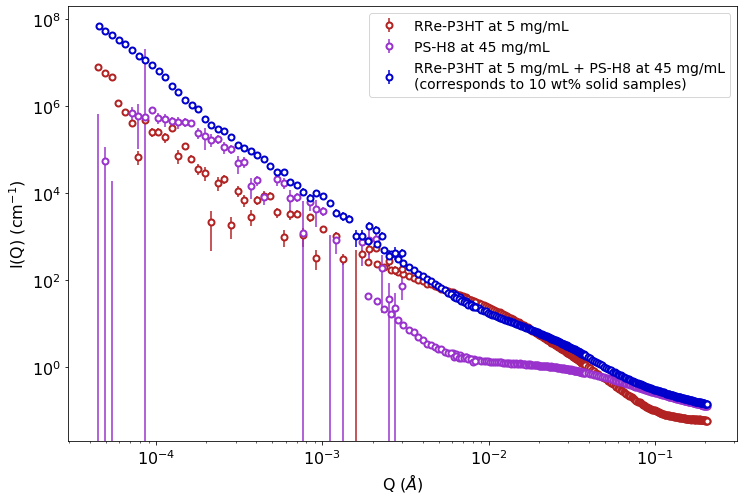

In [11]:
plt.figure(figsize=(12,8))
keys = ['TU11','TU20','TU19']
for key,color in zip(keys,colors):
    sans_load = sans_data[key]
    plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],label=names[key],mfc='white',mew=2)
    if key in usans_data.keys():
        usans = usans_data[key]
        plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mfc='white',mew=2)

plt.legend(fontsize=14)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Q $(\AA)$',fontsize=16)
plt.ylabel(r'I(Q) (cm$^{-1}$)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

## RRe-P3HT at 5 mg/mL Sample (TU11)

In [51]:
(sld.value - sld_solvent.value)**2

24.880143999999994

final chisq 762592.888(22)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                         cylinder length 101.67(10)e3    101669.55(12)  
                         cylinder radius 155.182(58)     155.182314(66) 
                          cylinder scale 0.33918(26)     0.33917667(30) 
                          free chains rg 199.99793368(73) 199.99793368347(84)
                           power law exp 1.62580(13)     1.62579936(15) 
                         power law scale 8.7609(28)      8.7609047(32)  


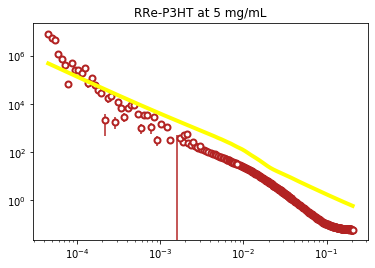

In [199]:
key = 'TU11'
kernel = load_model("cylinder+polymer_excl_volume+power_law")

# loading the data
sans_load = sans_data[key]
sans_load.dx = sans_load.dx-sans_load.dx # removing smearing from sans segment
usans = usans_data[key]

#mask = np.where(sans_load.x>0.001)
sans = sasmodels.data.Data1D(x=np.concatenate((sans_load.x[mask],usans.x)),y=np.concatenate((sans_load.y[mask],usans.y)),dy=np.concatenate((sans_load.dy[mask],usans.dy)))
#sans.mask = np.where((sans.x>0))

# initial parameter values

scale = Parameter(0.005/1.1, name='scale')
background = Parameter(np.average(sans.y[np.where(sans.x>0.2)]), name='background')

A_scale = Parameter(0.5, name = 'cylinder scale').range(0,1)

A_radius = Parameter(150,limits=[0,inf], name =  'cylinder radius').range(0,300)
A_radius_pd = Parameter(0.1, name =  'cylinder radius pd')
A_radius_pd_n = Parameter(200, name =  'cylinder radius pd n')
A_radius_pd_nsigma = Parameter(8, name =  ' cylinder radius pd nsigma') 
    
A_length = Parameter(100000,limits=[0,inf], name =  'cylinder length').range(0,inf)
A_length_pd = Parameter(0, name =  'cylinder length')
A_length_pd_n = Parameter(200, name =  ' cylinder length pd n')
A_length_pd_nsigma = Parameter(8, name = ' cylinder length pd nsigma') 

B_rg = Parameter(50,name='free chains rg').range(0,200)
B_porod_exp = Parameter(3,name='free chains porod exp')

sld = Parameter(slds[cps[key]])
sld_solvent = Parameter(slds[solvent_names[key]])

B_scale=(1-A_scale)*(sld.value-sld_solvent.value)**2
#B_scale = Parameter(0)

C_scale = Parameter(10,name='power law scale').range(0,inf)
#C_scale = Parameter(0)
C_power=Parameter(5/3,name='power law exp').range(1,4)

# setting up the combined model for fitting
sans_model = Model(
    model=kernel,
    scale=scale,
    background=background,
    A_scale=A_scale,
    A_radius=A_radius,
    A_radius_pd_type='lognormal',
    A_radius_pd = A_radius_pd,
    A_radius_pd_nsigma = A_radius_pd_nsigma,
    A_length=A_length,
    A_length_pd_type='lognormal',
    A_length_pd = A_length_pd,
    A_length_pd_nsigma = A_length_pd_nsigma,
    A_sld=sld,
    A_sld_solvent=sld_solvent,
    B_scale=B_scale,
    B_rg=B_rg,
    B_porod_exp=B_porod_exp,
    C_scale=C_scale,
    C_power=C_power,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)
result=fit(problem, method='lm',verbose=True)

plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')
plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mew=2,mfc='white')

sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='yellow')
plt.title(names[key])

plt.xscale('log')
plt.yscale('log')

final chisq 1.476(24)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              background 0.08238(83)     0.08238(68)    
                              cor_length 24.99(12)       24.993(99)     
                             lorentz_exp 1.9654(97)      1.9654(80)     
                           lorentz scale 1.2693(64)      1.2693(52)     
                               porod_exp 3.716(30)       3.716(25)      
                             porod_scale 3.81(65)e-9     3.81(53)e-9    


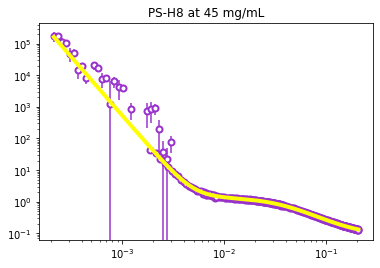

In [145]:
key = 'TU20'
kernel = load_model("correlation_length")

# loading the data
sans_load = sans_data[key]
sans_load.dx = sans_load.dx-sans_load.dx # removing smearing from sans segment
usans_load = usans_data[key]
mask = np.where((usans_load.x>2e-4)&(usans_load.y>1e-1))
usans = sasmodels.data.Data1D(x=usans_load.x[mask],y=usans_load.y[mask],dy=usans_load.dy[mask])

#sans = sasmodels.data.Data1D(x=sans_load.x[mask],y=sans_load.y[mask],dy=sans_load.dy[mask])
sans = sasmodels.data.Data1D(x=np.concatenate((sans_load.x,usans.x)),y=np.concatenate((sans_load.y,usans.y)),dy=np.concatenate((sans_load.dy,usans.dy)))

# initial parameter values

scale_H8 = Parameter(1,name="scale")
background_H8 = Parameter(0.08339, name = "background").range(0,1)
lorentz_scale_H8 = Parameter(1.2, name = "lorentz scale").range(0,inf)
porod_scale_H8 = Parameter(177.2e-9, name = "porod_scale").range(0,inf)
cor_length_H8 = Parameter(24.016, name = "cor_length").range(0,inf)
porod_exp_H8 = Parameter(3.5, name = "porod_exp").range(0,4)
lorentz_exp_H8 = Parameter(2, name = "lorentz_exp").range(0,4)

# setting up the combined model for fitting
sans_model = Model(
    model=kernel,
    scale=scale_H8,
    background=background_H8,
    lorentz_scale=lorentz_scale_H8,
    porod_scale=porod_scale_H8,
    cor_length=cor_length_H8,
    porod_exp=porod_exp_H8,
    lorentz_exp=lorentz_exp_H8,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)
result=fit(problem, method='lm',verbose=True)
#result = fit(problem, method='dream', verbose=True, steps=1000)

plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')
plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mew=2,mfc='white')

sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='yellow')
plt.title(names[key])
plt.xscale('log')
plt.yscale('log')

## PS-D8 at 45 mg/mL Sample (TU25)

final chisq 1.080(26)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              background 0.05300(59)     0.05300(57)    
                              cor_length 29.9(18)        29.9(17)       
                             lorentz_exp 1.732(84)       1.732(81)      
                           lorentz scale 0.0931(55)      0.0931(53)     
                               porod_exp 3.464(67)       3.464(64)      
                             porod_scale 4.6(17)e-9      4.6(16)e-9     


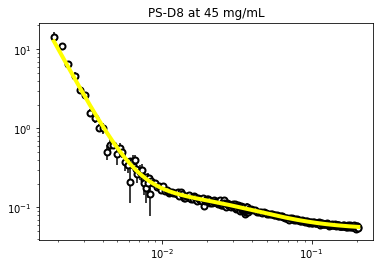

In [144]:
key = 'TU25'
kernel = load_model("correlation_length")

# loading the data
sans_load = sans_data[key]
sans_load.dx = sans_load.dx-sans_load.dx # removing smearing from sans segment
#usans_load = usans_data[key]
#mask = np.where((usans_load.x>2e-4)&(usans_load.y>1e-1))
#usans = sasmodels.data.Data1D(x=usans_load.x[mask],y=usans_load.y[mask],dy=usans_load.dy[mask])
mask = np.where(sans_load.x>1e-4)
sans = sasmodels.data.Data1D(x=sans_load.x[mask],y=sans_load.y[mask],dy=sans_load.dy[mask])
#sans = sasmodels.data.Data1D(x=np.concatenate((sans_load.x,usans.x)),y=np.concatenate((sans_load.y,usans.y)),dy=np.concatenate((sans_load.dy,usans.dy)))

# initial parameter values

scale_D8 = Parameter(1,name="scale")
background_D8 = Parameter(0.08339, name = "background").range(0,1)
lorentz_scale_D8 = Parameter(1.2, name = "lorentz scale").range(0,inf)
porod_scale_D8 = Parameter(177.2e-9, name = "porod_scale").range(0,inf)
cor_length_D8 = Parameter(24.016, name = "cor_length").range(0,inf)
porod_exp_D8 = Parameter(3.5, name = "porod_exp").range(0,4)
lorentz_exp_D8 = Parameter(2, name = "lorentz_exp").range(0,4)

# setting up the combined model for fitting
sans_model = Model(
    model=kernel,
    scale=scale_D8,
    background=background_D8,
    lorentz_scale=lorentz_scale_D8,
    porod_scale=porod_scale_D8,
    cor_length=cor_length_D8,
    porod_exp=porod_exp_D8,
    lorentz_exp=lorentz_exp_D8,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)
result=fit(problem, method='lm',verbose=True)
#result = fit(problem, method='dream', verbose=True, steps=1000)

plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')
#plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mew=2,mfc='white')

sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='yellow')
plt.title(names[key])
plt.xscale('log')
plt.yscale('log')

## RRe-P3HT at 5 mg/mL and PS-H8 at 45 mg/mL Sample (TU19)

final chisq 35.761(26)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                         cylinder length 190.72(28)e3    190720(47)     
                         cylinder radius 26.384(85)      26.384(14)     
                          cylinder scale 0.0015355(67)   0.0015355(11)  
                          free chains rg 5.15(11)        5.146(19)      
                           power law exp 2.4930(67)      2.4930(11)     
                         power law scale 84.2(29)e-6     84.25(49)e-6   
                              background 0.00(98)e-3     0.00(16)e-3    


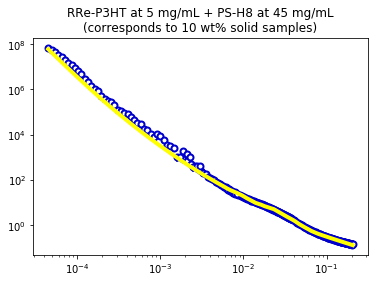

In [189]:
key = 'TU19'
kernel = load_model("cylinder+polymer_excl_volume+power_law+correlation_length")

# loading the data
sans_load = sans_data[key]
sans_load.dx = sans_load.dx-sans_load.dx # removing smearing from sans segment
usans = usans_data[key]

mask = np.where(sans_load.x>1e-5)
mask2 = np.where(usans.x>1e-5)
sans = sasmodels.data.Data1D(x=np.concatenate((sans_load.x[mask],usans.x[mask2])),y=np.concatenate((sans_load.y[mask],usans.y[mask2])),dy=np.concatenate((sans_load.dy[mask],usans.dy[mask2])))
#sans.mask = np.where((sans.x>0))

# initial parameter values

scale = Parameter(1, name='scale')
background = Parameter(0, name='background').range(0,0.1)

A_scale = Parameter(0.5*0.005/1.1, name = 'cylinder scale').range(0,1*0.005/1.1)

A_radius = Parameter(34,limits=[0,inf], name =  'cylinder radius').range(0,300)
A_radius_pd = Parameter(0.5, name =  'cylinder radius pd')
A_radius_pd_n = Parameter(200, name =  'cylinder radius pd n')
A_radius_pd_nsigma = Parameter(8, name =  ' cylinder radius pd nsigma') 
    
A_length = Parameter(200000,limits=[0,inf], name =  'cylinder length').range(10000,inf)
A_length_pd = Parameter(0, name =  'cylinder length pd')
A_length_pd_n = Parameter(200, name =  ' cylinder length pd n')
A_length_pd_nsigma = Parameter(8, name = ' cylinder length pd nsigma') 

B_rg = Parameter(6,name='free chains rg').range(0,100000)
B_porod_exp = Parameter(3,name='free chains porod exp')

sld = Parameter(slds[cps[key]])
sld_solvent = Parameter(slds[solvent_names[key]])

B_scale=(1-A_scale)*(sld.value-sld_solvent.value)**2*0.005/1.1

C_scale = Parameter(0.000090,name='power law scale').range(0,inf)
C_power=Parameter(2.5,name='power law exp').range(1,4)

D_scale = Parameter(1)
#D_scale=Parameter(0)
D_lorentz_scale = Parameter(lorentz_scale_H8.value/scale.value)
D_porod_scale = Parameter(porod_scale_H8.value/scale.value)
D_cor_length = Parameter(cor_length_H8.value)
D_porod_exp = Parameter(porod_exp_H8.value)
D_lorentz_exp = Parameter(lorentz_exp_H8.value)

# setting up the combined model for fitting
sans_model = Model(
    model=kernel,
    scale=scale,
    background=background,
    A_scale=A_scale,
    A_radius=A_radius,
    A_radius_pd_type='lognormal',
    A_radius_pd = A_radius_pd,
    A_radius_pd_nsigma = A_radius_pd_nsigma,
    A_length=A_length,
    A_length_pd_type='lognormal',
    A_length_pd = A_length_pd,
    A_length_pd_nsigma = A_length_pd_nsigma,
    A_sld=sld,
    A_sld_solvent=sld_solvent,
    B_scale=B_scale,
    B_rg=B_rg,
    B_porod_exp=B_porod_exp,
    C_scale=C_scale,
    C_power=C_power,
    D_scale = D_scale,
    D_lorentz_scale = D_lorentz_scale,
    D_porod_scale = D_porod_scale,
    D_cor_length = D_cor_length,
    D_porod_exp = D_porod_exp,
    D_lorentz_exp = D_lorentz_exp,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)
result=fit(problem, method='lm',verbose=True)

plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')
plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mew=2,mfc='white')

sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='yellow')
plt.title(names[key])

plt.xscale('log')
plt.yscale('log')

In [190]:
A_scale.value*1.1/0.005

0.3378151351115443

final chisq 20.914(30)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                         cylinder length 191.11(35)e3    191106(76)     
                         cylinder radius 28.52(35)       28.519(76)     
                          cylinder scale 0.0010744(60)   0.0010744(13)  
                          free chains rg 57.4(99)        57.4(22)       
                           power law exp 2.573(13)       2.5732(28)     
                         power law scale 93.3(67)e-6     93.3(15)e-6    
                              background 0.05012(26)     0.050116(57)   


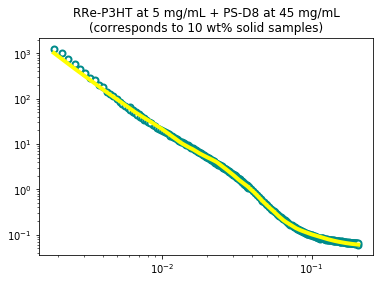

In [193]:
key = 'TU24'
kernel = load_model("cylinder+polymer_excl_volume+power_law+correlation_length")

# loading the data
sans_load = sans_data[key]
sans_load.dx = sans_load.dx-sans_load.dx # removing smearing from sans segment
#usans = usans_data[key]

mask = np.where(sans_load.x>1e-5)
#mask2 = np.where(usans.x>1e-5)
#sans = sasmodels.data.Data1D(x=np.concatenate((sans_load.x[mask],usans.x[mask2])),y=np.concatenate((sans_load.y[mask],usans.y[mask2])),dy=np.concatenate((sans_load.dy[mask],usans.dy[mask2])))
sans = sasmodels.data.Data1D(x=sans_load.x[mask],y=sans_load.y[mask],dy=sans_load.dy[mask])

#sans.mask = np.where((sans.x>0))

# initial parameter values

scale = Parameter(1, name='scale')
background = Parameter(0.06, name='background').range(0,0.1)
#background = Parameter(np.average(sans.x[np.where(sans.x>0.17)]))

A_scale = Parameter(0.01, name = 'cylinder scale').range(0,1*0.005/1.1)

A_radius = Parameter(34,limits=[0,inf], name =  'cylinder radius').range(0,300)
A_radius_pd = Parameter(0.5, name =  'cylinder radius pd')
A_radius_pd_n = Parameter(200, name =  'cylinder radius pd n')
A_radius_pd_nsigma = Parameter(8, name =  ' cylinder radius pd nsigma') 
    
A_length = Parameter(200000,limits=[0,inf], name =  'cylinder length').range(10000,inf)
A_length_pd = Parameter(0, name =  'cylinder length pd')
A_length_pd_n = Parameter(200, name =  ' cylinder length pd n')
A_length_pd_nsigma = Parameter(8, name = ' cylinder length pd nsigma') 

B_rg = Parameter(6,name='free chains rg').range(0,100000)
B_porod_exp = Parameter(3,name='free chains porod exp')

sld = Parameter(slds[cps[key]])
sld_solvent = Parameter(slds[solvent_names[key]])

B_scale=(1-A_scale)*(sld.value-sld_solvent.value)**2*0.005/1.1

C_scale = Parameter(0.000090,name='power law scale').range(0,inf)
C_power=Parameter(2.5,name='power law exp').range(1,4)

D_scale = Parameter(1)
#D_scale=Parameter(0)
D_lorentz_scale = Parameter(lorentz_scale_D8.value/scale.value)
D_porod_scale = Parameter(porod_scale_D8.value/scale.value)
D_cor_length = Parameter(cor_length_D8.value)
D_porod_exp = Parameter(porod_exp_D8.value)
D_lorentz_exp = Parameter(lorentz_exp_D8.value)

# setting up the combined model for fitting
sans_model = Model(
    model=kernel,
    scale=scale,
    background=background,
    A_scale=A_scale,
    A_radius=A_radius,
    A_radius_pd_type='lognormal',
    A_radius_pd = A_radius_pd,
    A_radius_pd_nsigma = A_radius_pd_nsigma,
    A_length=A_length,
    A_length_pd_type='lognormal',
    A_length_pd = A_length_pd,
    A_length_pd_nsigma = A_length_pd_nsigma,
    A_sld=sld,
    A_sld_solvent=sld_solvent,
    B_scale=B_scale,
    B_rg=B_rg,
    B_porod_exp=B_porod_exp,
    C_scale=C_scale,
    C_power=C_power,
    D_scale = D_scale,
    D_lorentz_scale = D_lorentz_scale,
    D_porod_scale = D_porod_scale,
    D_cor_length = D_cor_length,
    D_porod_exp = D_porod_exp,
    D_lorentz_exp = D_lorentz_exp,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)
result=fit(problem, method='lm',verbose=True)

plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')
#plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mew=2,mfc='white')

sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='yellow')
plt.title(names[key])

plt.xscale('log')
plt.yscale('log')

In [194]:
A_scale.value*1.1/0.005

0.23635844398095124

## Plotting Fit Results

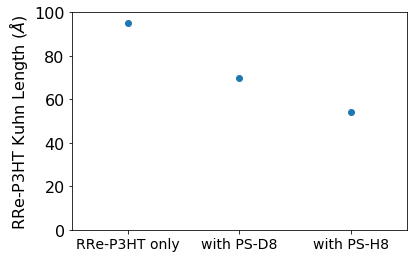

In [160]:
# RRe-P3HT Kuhn Length
x = [1,2,3]
y = [kuhn_length.value, B_kuhn_length_D8.value, B_kuhn_length_H8.value]
labels = ['RRe-P3HT only', 'with PS-D8', 'with PS-H8']

plt.scatter(x,y)
plt.xticks(x,labels=labels,fontsize=14)
plt.yticks(fontsize=16)
plt.ylabel('RRe-P3HT Kuhn Length ($\AA$)',fontsize=16)
plt.xlim(0.5,3.5)
plt.ylim(0,100)
plt.show()

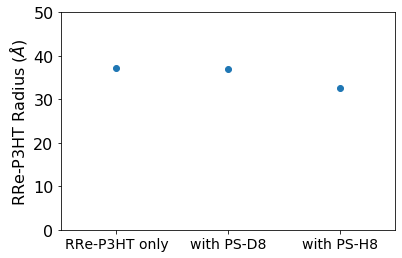

In [161]:
# RRe-P3HT Radius
x = [1,2,3]
y = [radius.value, B_radius_D8.value, B_radius_H8.value]
labels = ['RRe-P3HT only', 'with PS-D8', 'with PS-H8']

plt.scatter(x,y)
plt.xticks(x,labels=labels,fontsize=14)
plt.yticks(fontsize=16)
plt.ylabel('RRe-P3HT Radius ($\AA$)',fontsize=16)
plt.xlim(0.5,3.5)
plt.ylim(0,50)
plt.show()

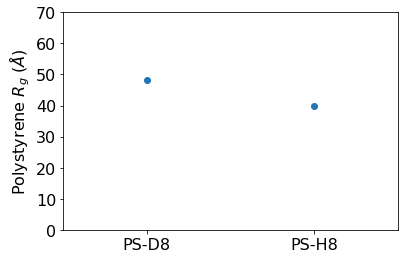

In [162]:
# PS Rg
x = [1,2]
y = [rg_D8.value, rg_H8.value]
labels = ['PS-D8', 'PS-H8']

plt.scatter(x,y)
plt.xticks(x,labels=labels,fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Polystyrene $R_g$ ($\AA$)',fontsize=16)
plt.xlim(0.5,2.5)
plt.ylim(0,70)
plt.show()